<a href="https://colab.research.google.com/github/gladcolor/segregation_index/blob/master/Residential_Segregation_Huan_V4_state_level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [1]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 13.4 MB/s 
     |████████████████████████████████| 15.4 MB 50.9 MB/s 
     |████████████████████████████████| 6.3 MB 52.2 MB/s 


# Load packages

In [2]:
import pandas as pd
import os
import sys
import math
import numpy as np
import ast
import geopandas as gpd

from urllib.request import urlopen
from zipfile import ZipFile

import requests
from io import StringIO

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.dates import MonthLocator, DateFormatter

from shapely.geometry import Point

# Load tracts and counties shapefiles

If you need to link to you Google drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# go go the working directory
% cd /content/drive/MyDrive/Research/segregation

Mounted at /content/drive
/content/drive/MyDrive/Research/segregation


In [171]:
plt.rcParams['figure.figsize'] = (15, 12) #set default figure size

# shapefile_url = r'https://github.com/GIBDUSC/Twitter-derived-human-mobility/raw/master/sc_tract.zip'

# North American Equidistance conic:  +proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs 
# https://epsg.io/102010
equidistance_crs = r'+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs '

shapefile_url = r'/content/drive/MyDrive/Research/Homophily/tract_shape.zip'
tract_gdf = gpd.read_file(shapefile_url)    #.to_crs('EPSG:6569')   # EPSG:6569:  NAD83(2011) / South Carolina

state_shapefile_url = r'https://github.com/gladcolor/segregation_index/raw/master/cb_2018_us_state_20m.zip'
state_gdf = gpd.read_file(state_shapefile_url).to_crs(equidistance_crs) 

us_tract_gdf = tract_gdf.to_crs(equidistance_crs)
# us_tract_gdf
# state_gdf


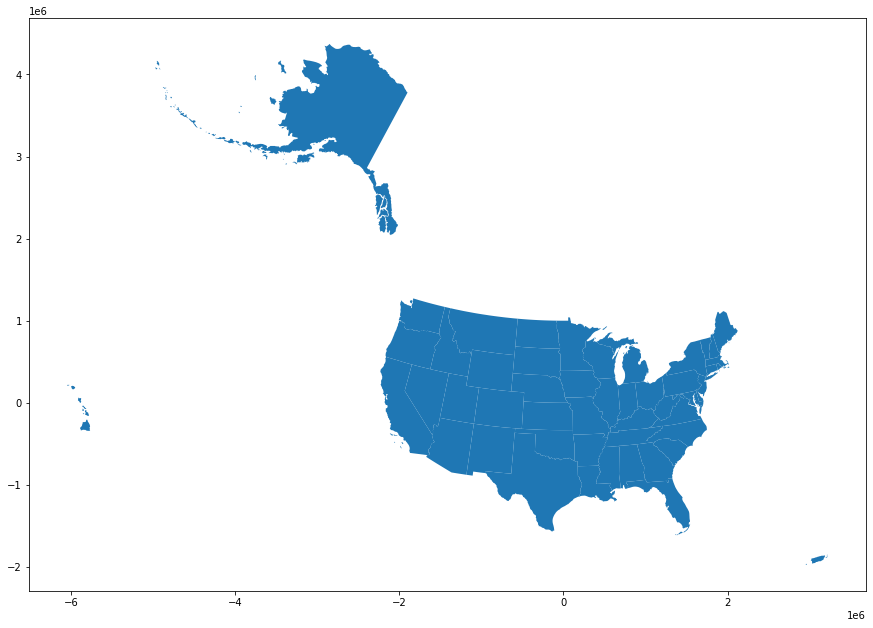

In [107]:
# us_tract_gdf.plot()
state_gdf.plot()

In [118]:
shapefile_url = r'https://github.com/GIBDUSC/test/raw/master/us_counties.zip'

# county_gdf = gpd.read_file(shapefile_url).to_crs("EPSG:2163")
us_county_gdf = gpd.read_file(shapefile_url)# .to_crs(r'+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
us_county_gdf = us_county_gdf.drop(columns=['fips_1', 'average_20', 'complete_2', 'average_48', 'complete_4', 'average_50', 'complete_5', 'average_75', 'complete_7'])
us_county_gdf = us_county_gdf.fillna("--") # ['County', 'Parish', 'city', '--', 'CA', 'Borough', 'Cty&Bor', 'Muny', 'Muno']
print("Coordinate systems:", us_county_gdf.crs)
print(f"Len(county_gdf): {len(us_county_gdf)}")

# print(us_county_gdf.columns)

# us_county_gdf['fips']
us_county_gdf['fips'] = us_county_gdf['FIPS'].str[2:]
# us_county_gdf['fips']

# print(us_county_gdf.columns)

# county_gdf =  county_gdf.loc[county_gdf.STATE=="45"]

state_csv = r'https://raw.githubusercontent.com/gladcolor/homophily/master/state_code.csv'
state_df = pd.read_csv(state_csv, dtype=str)
state_df.columns = ['State_Name', 'State_Abbreviation', 'State_FIPS']
us_county_gdf = us_county_gdf.merge(state_df, left_on='STATE', right_on='State_FIPS')
us_county_gdf['FIPS'] = us_county_gdf['FIPS'].str[2:]
us_county_gdf = us_county_gdf.drop(columns=['fips'])
# print(us_county_gdf.columns)

print(us_county_gdf['State_Name'].unique())


county_name_df = us_county_gdf[['NAME', 'FIPS','State_Name','State_Abbreviation','State_FIPS']]


# county_gdf = gpd.read_file(shapefile_url).to_crs("EPSG:2163")
# us_county_gdf = gpd.read_file(shapefile_url)# .to_crs(r'+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
print("Coordinate systems:", us_county_gdf.crs)
print(f"Len(county_gdf): {len(us_county_gdf)}")

state_codes =  us_county_gdf['STATE'].unique() 
print("To process state code count: ", len(state_codes))

# us_county_gdf.plot()

Coordinate systems: epsg:4326
Len(county_gdf): 3221
['Alabama' 'Arkansas' 'California' 'Colorado' 'Florida' 'Georgia'
 'Connecticut' 'Arizona' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Minnesota' 'Mississippi' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New Jersey' 'New Mexico' 'North Carolina' 'Ohio' 'Oklahoma'
 'North Dakota' 'New York' 'Pennsylvania' 'South Carolina' 'Tennessee'
 'South Dakota' 'Oregon' 'Texas' 'Utah' 'Virginia' 'Washington'
 'Wisconsin' 'Wyoming' 'West Virginia' 'Vermont' 'Delaware'
 'District of Columbia' 'New Hampshire' 'Rhode Island' 'Alaska' 'Hawaii'
 'Puerto Rico']
Coordinate systems: epsg:4326
Len(county_gdf): 3221
To process state code count:  52


In [119]:
us_county_gdf

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,FIPS,geometry,State_Name,State_Abbreviation,State_FIPS
0,0500000US01001,01,001,Autauga,County,594.436,01001,"POLYGON Z ((-86.49677 32.34444 0.00000, -86.71...",Alabama,AL,01
1,0500000US01009,01,009,Blount,County,644.776,01009,"POLYGON Z ((-86.57780 33.76532 0.00000, -86.75...",Alabama,AL,01
2,0500000US01017,01,017,Chambers,County,596.531,01017,"POLYGON Z ((-85.18413 32.87053 0.00000, -85.12...",Alabama,AL,01
3,0500000US01021,01,021,Chilton,County,692.854,01021,"POLYGON Z ((-86.51734 33.02057 0.00000, -86.51...",Alabama,AL,01
4,0500000US01033,01,033,Colbert,County,592.619,01033,"POLYGON Z ((-88.13999 34.58170 0.00000, -88.13...",Alabama,AL,01
...,...,...,...,...,...,...,...,...,...,...,...
3216,0500000US72141,72,141,Utuado,Muno,113.529,72141,"POLYGON Z ((-66.67049 18.15283 0.00000, -66.69...",Puerto Rico,PR,72
3217,0500000US72071,72,071,Isabela,Muno,55.304,72071,"POLYGON Z ((-66.95752 18.48917 0.00000, -66.92...",Puerto Rico,PR,72
3218,0500000US72003,72,003,Aguada,Muno,30.851,72003,"POLYGON Z ((-67.18285 18.31303 0.00000, -67.23...",Puerto Rico,PR,72
3219,0500000US72009,72,009,Aibonito,Muno,31.311,72009,"POLYGON Z ((-66.22449 18.09534 0.00000, -66.22...",Puerto Rico,PR,72


# Process each state

Find which state should be processed

In [8]:
# state_csv = r'https://raw.githubusercontent.com/gladcolor/homophily/master/state_code.csv'
# state_df = pd.read_csv(state_csv, dtype=str)
# state_df.columns = ['State_Name', 'State_Abbreviation', 'State_FIPS']
# us_county_gdf = us_county_gdf.merge(state_df, left_on='STATE', right_on='State_FIPS')

# state_codes =  us_county_gdf['STATE'].unique() 

# print("To process state code count: ", len(state_codes))
# print(us_county_gdf['State_Name'].unique())

## Define functions to compute segregation index

In [120]:
def calculate_dissimilarity(df):
    result =   (df['BlackAfricanAmerican'] / df['BlackAfricanAmericanSum'] - df['White'] / df['WhiteSum']).abs().sum() * 0.5
    return result

def calculate_isolation(df):
    # zero_idx = df['TotalPopulation'] == 0
    # if zero_idx.sum() > 0:
        # df.loc[zero_idx, 'TotalPopulation'] = 1
        # print(df.loc[zero_idx, ['FIPS', 'CountyFIPS', 'StateAbbreviation', 'White', 'BlackAfricanAmerican', 'TotalPopulation']])
        # print(f"When commputing Isolation Index, found  above {zero_idx.sum()} TotalPopulation = 0, have set TotalPopulation = 1 to avoid 'divided by zero'.")

    # Not used
    # result = ((df['BlackAfricanAmerican'] / df['BlackAfricanAmericanSum']) * (df['White'] / df['TotalPopulation'])).sum()
    #                    m_i                            sum(m_i)      r_i (white: reference)      t_i = r_i + m_i

    result = ((df['BlackAfricanAmerican'] / df['BlackAfricanAmericanSum']) * (df['BlackAfricanAmerican'] / df['TotalPopulation'])).sum()

    return result

def calculate_delta(df):
    result = (df['BlackAfricanAmerican'] / df['BlackAfricanAmericanSum'] - df['AreaTotal'] / df['AreaTotalSum']).abs().sum() * 0.5
    return result

# do not understand yet. Huan
def calculate_centralization0(df):
    df = df.sort_values("AreaTotal").reset_index()
    N = len(df)
    sum_m_i = 0
    sum_m_i_1 = 0
    # print(df)
    for i in range(1, N):
        m_i = df.at[i, 'BlackAfricanAmerican']
        m_i_1 = df.at[i - 1, 'BlackAfricanAmerican']

        a_i = df.at[i, 'AreaTotal']
        a_i_1 = df.at[i - 1, 'AreaTotal']

        sum_m_i += m_i_1 * a_i
        sum_m_i_1 += m_i * a_i_1
    
    ACI = sum_m_i - sum_m_i_1

    return ACI

# compute the cumulated ratio
def get_relative_centralization(df, method='relative'):
    # method is in ['relative', 'absolute']
    # df is sorted.
    RCI_sum1 = 0
    RCI_sum2 = 0
    ACI_sum1 = 0
    ACI_sum2 = 0
    # print(len(df))
    assert method in ['relative', 'absolute']
    
    for j in range(1, len(df)):   # X: black, Y: white
        X_j_1 = df.loc[j-1, 'Black_to_CBD_dis_cum']
        X_j   = df.loc[j,   'Black_to_CBD_dis_cum']
        Y_j_1 = df.loc[j-1, 'White_to_CBD_dis_cum']
        Y_j   = df.loc[j,   'White_to_CBD_dis_cum']
        A_j   = df.loc[j,   'Area_cum']
        A_j_1 = df.loc[j,   'Area_cum']
        
        RCI_sum1 += X_j_1 * Y_j
        RCI_sum2 += X_j   * Y_j_1

        ACI_sum1 = X_j_1 * A_j
        ACI_sum2 = X_j   * A_j_1

    RCI = RCI_sum1 - RCI_sum2
    ACI = ACI_sum1 - ACI_sum2
    if method == 'relative':
        return RCI    
    if method == 'absolute':
        return ACI    


def calculate_centralization(county_df, method='relative'):
    county_df = county_df.sort_values('distance_to_CBD').reset_index()

    county_df.loc[:, 'Whitesum'] = county_df['White'].sum()
    county_df.loc[:, 'White_to_CBD_dis_cum'] = county_df['White'].cumsum() / county_df['Whitesum']

    county_df.loc[:, 'Blacksum'] = county_df['BlackAfricanAmerican'].sum()
    county_df.loc[:, 'Black_to_CBD_dis_cum'] = county_df['BlackAfricanAmerican'].cumsum() / county_df['Blacksum']

    county_df.loc[:, 'Area_cum'] = county_df['AreaTotal'].cumsum() / county_df['AreaTotalSum']

    county_df.loc[:, 'relative_centralization'] = get_relative_centralization(county_df)
    
    RCI = get_relative_centralization(county_df, method=method)
 
    return RCI


def calculate_absolute_centralization(county_df):
    ACI = calculate_centralization(county_df, method='absolute')
    return ACI

def calculate_proximity(df): 
    """
    df: all Census tracts of a county
    """
    # print(df.info())
    lon_0 = df.to_crs(4326).centroid.x.mean()  # central lon
    lat_0 = df.to_crs(4326).centroid.y.mean()   # central lat

    local_crs = f'+proj=tmerc +lat_0={lat_0} +lon_0={lon_0} +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'
    df = df.to_crs(local_crs)
    df['area'] = df['geometry'].area
    # print(df.crs)
    df = df.reset_index()
    N = len(df)
    # print((df))
    Pxx = 0
    Prr = 0
    Ptt = 0

    cenroids = df['geometry'].centroid
    # print(cenroids)
    
    for i in range(N):  # for every i (a Census tract)
        # a_i = df.at[i, 'AreaTotal']     # area of a tract i
        a_i = df.at[i, 'area'] / 1000000   # unit: square kilo-meter    # area of a tract i
        
        # e_exp_i = math.sqrt(0.6 * a_i)
        # d_ii = e_exp_i

        m_i = df.at[i, 'BlackAfricanAmerican']     # minority population (Black) of tract i
        
        
        r_i = df.at[i, 'White']    # reference population  (White) of tract i
        

        t_i = df.at[i, 'TotalPopulation']  # population of tract i
        

        center_point = cenroids.iloc[i]
        distances = cenroids.distance(center_point)
        # print(distances)
        
        M = df.at[i, 'BlackAfricanAmericanSum']    # sum of minority population in this county
        R = df.at[i, 'WhiteSum']    # sum of reference population in this county
        T = df.at[i, 'TotalPopulationSum']   # sum of total population in this county

        # for j in range(i, N):   # Do not get the same result as range(N). 
        for j in range(N):   # for every j (a Census tract)  
            # for every pair of i, j (two Census tracts)
            # a_j = df.at[j, 'AreaTotal']     # area of a tract j
            # e_exp_j = math.sqrt(0.6 * a_j)

            # d_jj = e_exp_j

            # d_ij = d_ii + d_jj

            d_ij = distances[j] / 1000   # unit: kilo-meter
            if i == j:
                d_ij = math.sqrt(0.6 * a_i)
            # print(i, j, d_ij)

            c_ij = math.exp(-d_ij)

            # print(r'i, j, c_ij:', i, j, c_ij)

            m_j = df.at[j, 'BlackAfricanAmerican']     # minority population (Black) of tract j
            Pxx += m_i * m_j *  c_ij / M**2

            r_j = df.at[j, 'White']     # reference population  (White) of tract j
            Prr += r_i * r_j * c_ij / R**2

            t_j = df.at[j, 'TotalPopulation']     # population of  tract j
            Ptt += t_i * t_j * c_ij / T**2

            # print(r'M, Pxx, R, Prr, T, Ptt:', M, Pxx, R, Prr, T, Ptt)

    
    SPI = (M * Pxx*2 + R * Prr*2) / (T * Ptt*2)

    # print(df.iloc[0]['FIPS'], SPI)
    
    
    return SPI

## Load population data set



In [130]:
def load_year_data(year):

    year_list = ["2009-2013", "2010-2014", "2011-2015", "2012-2016", "2013-2017", "2014-2018", "2015-2019"]

    assert(year in year_list), f"Year is not in {year_list}."
    census = f'https://github.com/gladcolor/segregation_index/raw/master/data_us_tract/{year}.zip'

    us_tract_pop_df = pd.read_csv(census)
    if us_tract_pop_df.columns[0] != "FIPS":
        us_tract_pop_df = us_tract_pop_df.iloc[:, 1:] 
    row_cnt_has_na = len(us_tract_pop_df)

    us_tract_pop_df = us_tract_pop_df.dropna()
    row_cnt_na = row_cnt_has_na - len(us_tract_pop_df)

    print(f"Loading data, year: {year}")

    us_tract_pop_df.loc[:, 'CountyFIPS'] = us_tract_pop_df['CountyFIPS'].astype(float).astype(int).astype(str).str.zfill(5)
    # print(us_tract_pop_df.dtypes)
    us_tract_pop_df.loc[:, 'Tract_FIPS'] = us_tract_pop_df['FIPS'].astype(str).str.zfill(11)

    print(f'Found rows: {len(us_tract_pop_df)}, after removing {row_cnt_na} nan row(s).')

    zero_idx = (us_tract_pop_df['TotalPopulation'] == 0)  
    if zero_idx.sum() > 0:  
        print(us_tract_pop_df.loc[zero_idx, ['FIPS', 'CountyFIPS', 'StateAbbreviation', 'White', 'BlackAfricanAmerican', 'TotalPopulation']])
        # us_tract_pop_df.loc[zero_idx, 'BlackAfricanAmerican'] = 1
        print()
        us_tract_pop_df = us_tract_pop_df[~zero_idx]
        print(f"Found above {zero_idx.sum()} rows that TotalPopulation number == 0, have dropped them.\n")

    # if a value == 0, make it == 1, to avoid divided by zero.
    zero_idx = (us_tract_pop_df['White'] == 0)    
    if zero_idx.sum() > 0:
        print(us_tract_pop_df.loc[zero_idx, ['FIPS', 'CountyFIPS', 'StateAbbreviation', 'White']])
        # us_tract_pop_df.loc[zero_idx, 'White'] = 1
        print()
        print(f"Found above {zero_idx.sum()} rows that White number == 0, have set it to 1 to avoid 'divded by zero'.")


    zero_idx = (us_tract_pop_df['BlackAfricanAmerican'] == 0 ) 
    if zero_idx.sum() > 0:  
        print(us_tract_pop_df.loc[zero_idx, ['FIPS', 'CountyFIPS', 'StateAbbreviation', 'BlackAfricanAmerican']])
        # us_tract_pop_df.loc[zero_idx, 'BlackAfricanAmerican'] = 1
        print()
        print(f"Found above {zero_idx.sum()} rows that BlackAfricanAmerican number == 0, have set it to 1 to avoid 'divded by zero'.\n")



    # zero_idx = us_tract_pop_df['Asian'] == 0    
    # us_tract_pop_df.loc[zero_idx, 'Asian'] = 1
    print()

    return us_tract_pop_df



# -----------  test code-------------------------

"""
# year = "2009-2013"
# year = "2010-2014"
# year = "2011-2015"
#year = "2012-2016"
#year = "2013-2017"
# year = "2014-2018"
year = "2015-2019"

us_tract_pop_df = load_year_data(year)
us_county_pop_df = us_tract_pop_df.groupby('CountyFIPS').agg('sum').reset_index().drop(columns='FIPS')
us_county_pop_df['State_FIPS'] = us_county_pop_df['CountyFIPS'].str[:2]
us_county_pop_df

"""

'\n# year = "2009-2013"\n# year = "2010-2014"\n# year = "2011-2015"\n#year = "2012-2016"\n#year = "2013-2017"\n# year = "2014-2018"\nyear = "2015-2019"\n\nus_tract_pop_df = load_year_data(year)\nus_county_pop_df = us_tract_pop_df.groupby(\'CountyFIPS\').agg(\'sum\').reset_index().drop(columns=\'FIPS\')\nus_county_pop_df[\'State_FIPS\'] = us_county_pop_df[\'CountyFIPS\'].str[:2]\nus_county_pop_df\n\n'

## Download county polygons

Needs about 1 minutes, then project them into an equidistance projection.

In [132]:
def download_state_tract_gdf(state_codes):
    state_tract_gdf_dict = {}
    for state_code in state_codes:
        
        state_csv = f'https://github.com/gladcolor/segregation_index/raw/master/us_tract_shp/tract_shp_{state_code}.zip'
        state_gdf = gpd.read_file(state_csv).to_crs(equidistance_crs)
        state_tract_gdf_dict[state_code] = state_gdf
        print(f"Processed state code: {state_code}, got tract polygon records: {len(state_gdf)}")
    return state_tract_gdf_dict

def download_state_county_gdf(state_codes):
    state_county_gdf_dict = {}
    for state_code in state_codes:      
        # North American Equidistance conic:  +proj=eqdc +lat_0=0 +lon_0=0 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs
        state_county_gdf = us_county_gdf[us_county_gdf['State_FIPS'] == state_code]
        state_county_gdf = state_county_gdf.to_crs(equidistance_crs)
        #
        state_county_gdf_dict[state_code] = state_county_gdf
        print(f"Processed state code: {state_code}, got state_county_gdf polygon records: {len(state_county_gdf)}")
    return state_county_gdf_dict

# state_codes =  us_county_gdf['STATE'].unique()
# state_tract_gdf_dict = download_state_tract_gdf(state_codes)  
# state_county_gdf_dict = download_state_county_gdf(state_codes)  

# bottom_level_gdf_dict = state_county_gdf_dict
# bottom_level_gdf_dict: the bottom level to compute the Segregation Index for upper_level

In [133]:
# state_county_gdf_dict['45'].plot()

## Compute indices (20 minitues per year)


In [146]:
# define a visualization function
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_indices(result_gdf, indices_functions, fig_name):
    state_name = result_gdf.loc[0, 'State_Name']
    ax_row_cnt = 2
    ax_col_cnt = 3
    fig, axs = plt.subplots(ax_row_cnt, ax_col_cnt, figsize=(30, 20))
    # plt.tight_layout()

    for idx, key in enumerate(indices_functions.keys()):
        ax_row = int(idx / ax_col_cnt)
        ax_col = idx - ax_row * ax_col_cnt
        ax = axs[ax_row, ax_col]
        ax.axis("off")
        ax.set_title(key)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="7%", pad=0.1)
        equal_area_crs = 2163 # North America Albers Equal Area Conic
        lon_0 = result_gdf.to_crs(4326).centroid.x.mean()  # central lon
        lat_0 = result_gdf.to_crs(4326).centroid.y.mean()   # central lat
        # print('lon_0:', lon_0)
        # local_crs = f'+proj=tmerc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0={lon_0} +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs' 
        local_crs = f'+proj=tmerc +lat_0={lat_0} +lon_0={lon_0} +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'

        missing_kwds = dict(color='grey', label='No Data') # about 100 counties have no black.

        # i = result_gdf[key].isna()
        # print("Missing values:", result_gdf[i])

        # result_gdf.to_crs(local_crs).plot(
        result_gdf.to_crs(equal_area_crs).plot(
                                    ax=ax,
                                    column=key, 
                                    missing_kwds=missing_kwds, 
                                    cmap='Reds', 
                                    # legend_kwds={'orientation':'vertical',"label": key},
                                    legend=True,   
                                    cax=cax
                                    )

    
    year = fig_name.split('.')[0][-4:]
    tile = f'USA Segeregation Indices ({year})'
    fig.suptitle(tile, fontsize=24)
    plt.savefig(fig_name)
    print(f'Saved figure in {fig_name}')
        # plt.show()

    return plt


Working on: year 2009-2013
Loading data, year: 2009-2013
Found rows: 73996, after removing 5 nan row(s).
              FIPS CountyFIPS  ... BlackAfricanAmerican  TotalPopulation
43      1003990000      01003  ...                    0                0
107     1015981902      01015  ...                    0                0
108     1015981903      01015  ...                    0                0
868     1097990000      01097  ...                    0                0
1460    4012980000      04012  ...                    0                0
...            ...        ...  ...                  ...              ...
73926  72137990000      72137  ...                    0                0
73957  72143990000      72143  ...                    0                0
73971  72145990000      72145  ...                    0                0
73974  72147990000      72147  ...                    0                0
73989  72151990000      72151  ...                    0                0

[682 rows x 6 colu

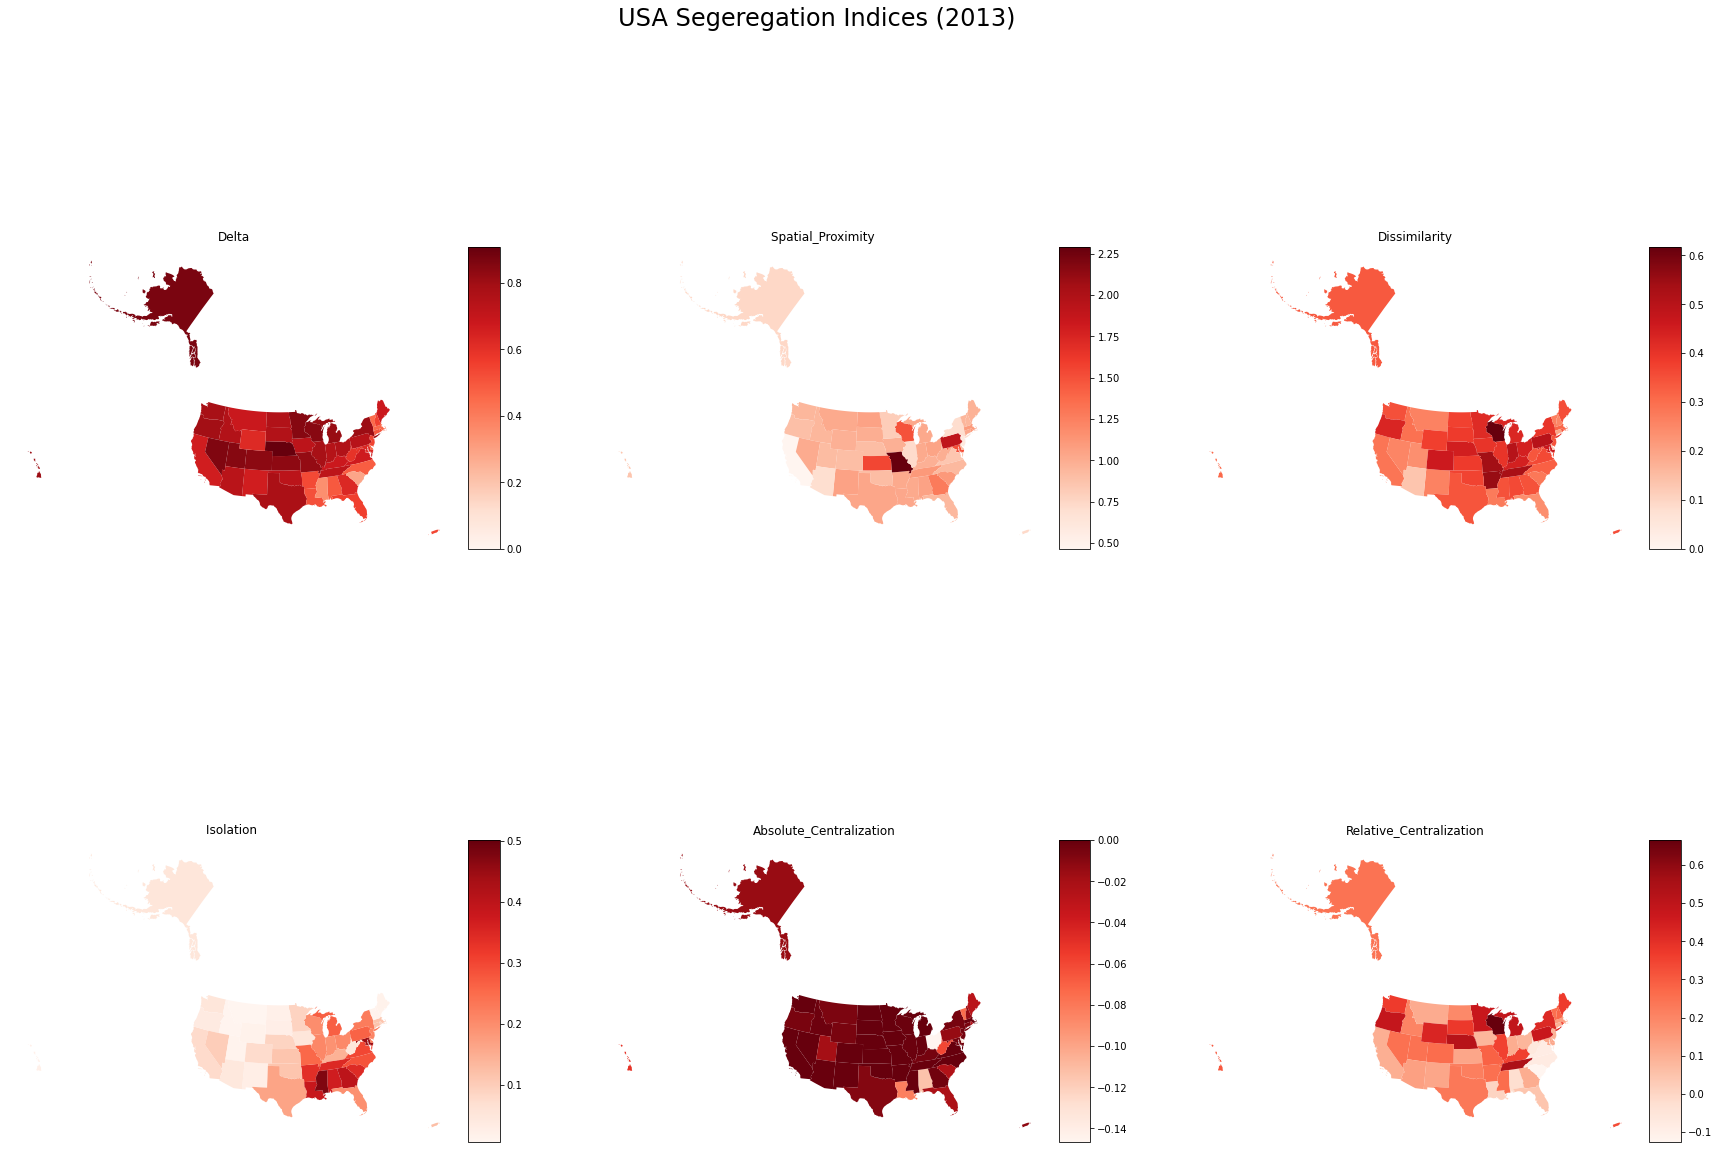

Working on: year 2010-2014
Loading data, year: 2010-2014
Found rows: 73922, after removing 79 nan row(s).
              FIPS CountyFIPS  ... BlackAfricanAmerican  TotalPopulation
43      1003990000      01003  ...                    0                0
107     1015981902      01015  ...                    0                0
108     1015981903      01015  ...                    0                0
868     1097990000      01097  ...                    0                0
1063    1117980000      01117  ...                    0                0
...            ...        ...  ...                  ...              ...
73926  72137990000      72137  ...                    0                0
73957  72143990000      72143  ...                    0                0
73971  72145990000      72145  ...                    0                0
73974  72147990000      72147  ...                    0                0
73989  72151990000      72151  ...                    0                0

[677 rows x 6 col

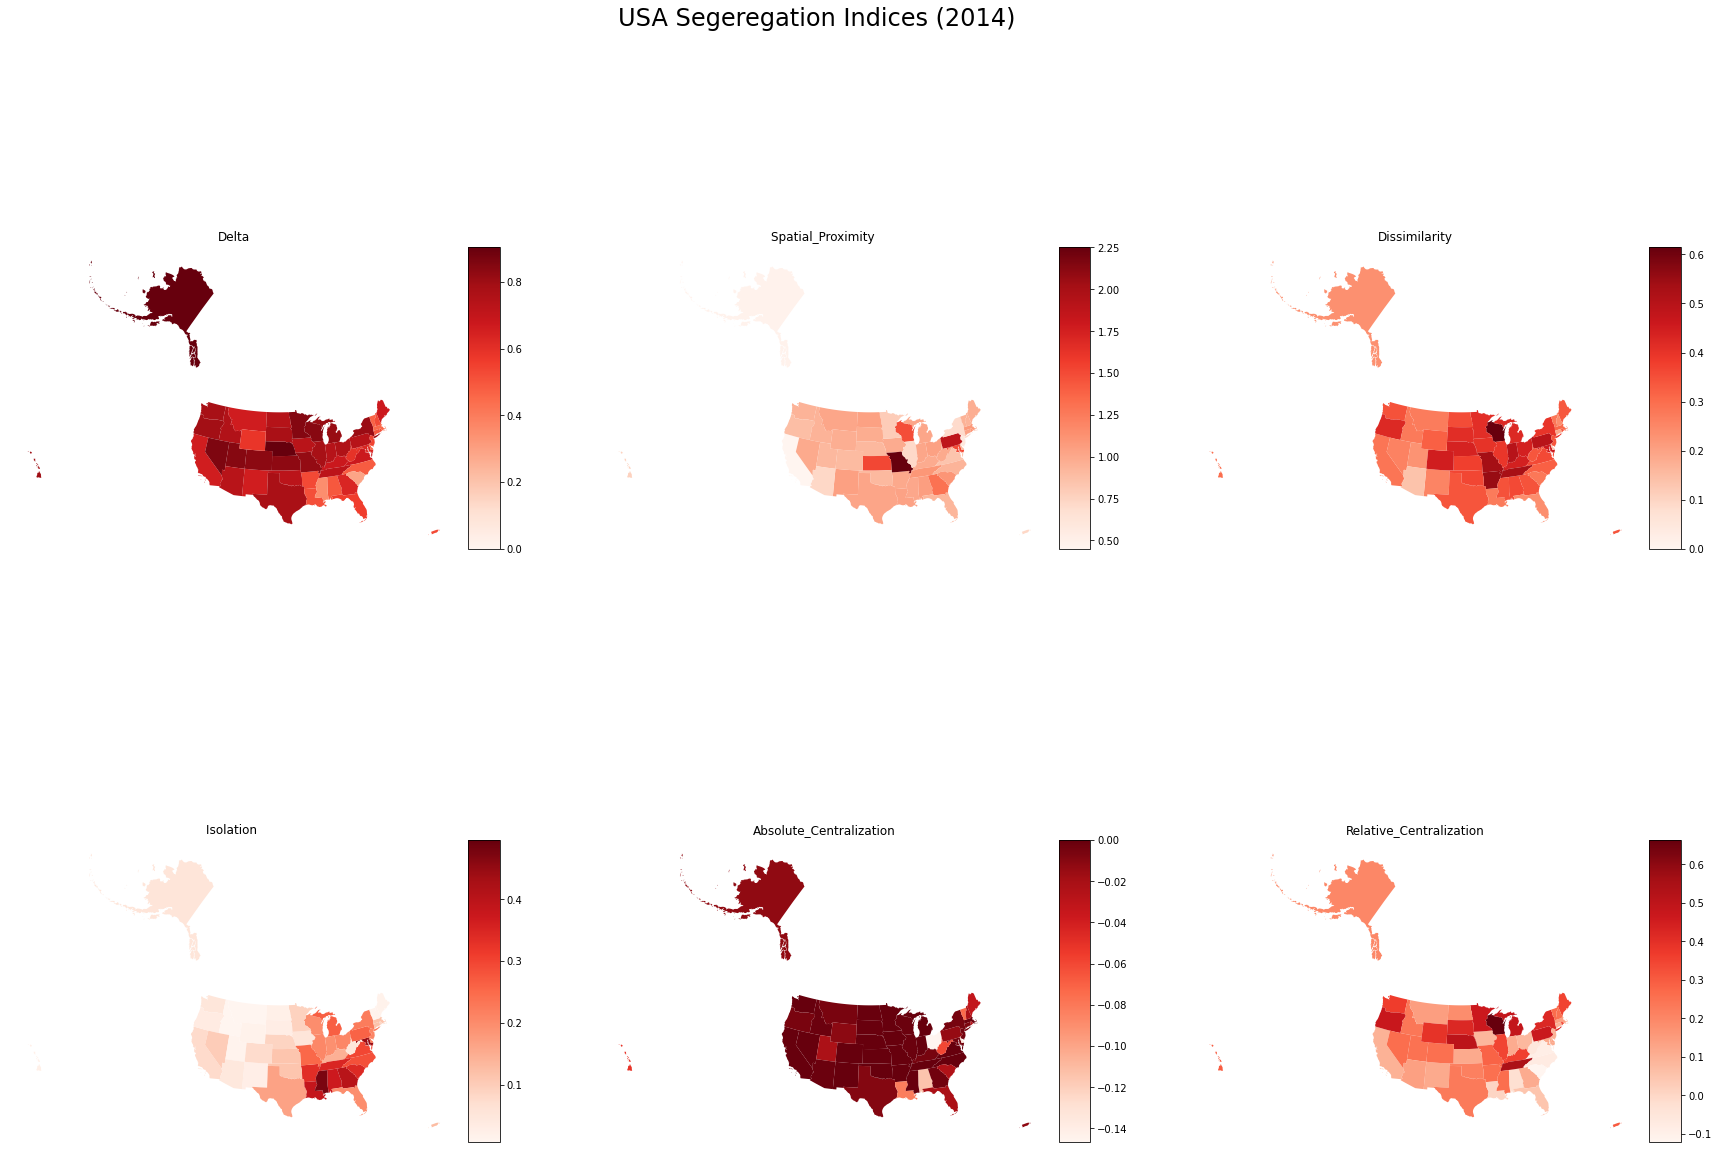

Working on: year 2011-2015
Loading data, year: 2011-2015
Found rows: 74001, after removing 0 nan row(s).
              FIPS CountyFIPS  ... BlackAfricanAmerican  TotalPopulation
43      1003990000      01003  ...                    0                0
107     1015981902      01015  ...                    0                0
108     1015981903      01015  ...                    0                0
868     1097990000      01097  ...                    0                0
1063    1117980000      01117  ...                    0                0
...            ...        ...  ...                  ...              ...
73926  72137990000      72137  ...                    0                0
73957  72143990000      72143  ...                    0                0
73971  72145990000      72145  ...                    0                0
73974  72147990000      72147  ...                    0                0
73989  72151990000      72151  ...                    0                0

[690 rows x 6 colu

In [ ]:
# Determine which index needs to be computed.
indices_functions = {
                    "Delta":calculate_delta,
                    "Spatial_Proximity ":calculate_proximity,
                    "Dissimilarity":calculate_dissimilarity,
                    "Isolation ":calculate_isolation,                    
                    "Absolute_Centralization":calculate_absolute_centralization,
                    "Relative_Centralization":calculate_centralization,
                    }

def compute_index(region_gdf, aggregate_column, indices_functions):
    """
    region_gdf: a gdf
    aggregate_column: 
    indices_functions: a dictionary
    """
    aggregated_df = region_gdf.groupby([aggregate_column]).agg(AreaTotalSum=('AreaTotal','sum'),
                                        TotalPopulationSum=('TotalPopulation','sum'),
                                        WhiteSum=('White','sum'),
                                        BlackAfricanAmericanSum=('BlackAfricanAmerican','sum')
                                        )
    
    merged_region_gdf = region_gdf.merge(aggregated_df, how='left', left_on=aggregate_column, right_on=aggregate_column)

    merged_region_gdf = compute_CDB_distance_rank(merged_region_gdf, aggregate_column)

    result_df_list = [] # put the results here

    for key in indices_functions.keys():

        print("Calculating index of:", key)

        result_df = merged_region_gdf.groupby(aggregate_column).apply(
            indices_functions[key]   
        ).reset_index(name=key)  #  name=key


        result_df.loc[:, aggregate_column] = result_df[aggregate_column].astype(str)
        #county_gdf['fips'] = county_gdf['fips'].astype(str)
        result_df_list.append(result_df)

    # merge the results
    results_all_df = pd.DataFrame()
    results_all_df.loc[:,aggregate_column] = result_df.iloc[:, 0]
    for df in result_df_list:
        column_name = df.columns[1]
        results_all_df[column_name] = df.loc[:, column_name]
    
    return results_all_df

# Calculate CDB and distances to the CDB
def compute_CDB_distance_rank(AOI_pop_gdf, aggregate_column):  
    # rand the population                   
    AOI_pop_gdf.loc[:, 'pop_density'] = AOI_pop_gdf['TotalPopulation']  / AOI_pop_gdf['AreaTotal']
    # print(AOI_pop_gdf.columns)
    # return AOI_pop_gdf.groupby([aggregate_column])['pop_density'].rank('dense', ascending=False)
    AOI_pop_gdf.loc[:, 'pop_density_rank'] = AOI_pop_gdf.groupby([aggregate_column])['pop_density'].rank('dense', ascending=False).astype(int)
    
    AOI_pop_gdf.loc[:, 'pop_rank'] = AOI_pop_gdf.groupby([aggregate_column])['TotalPopulation'].rank('dense', ascending=False).astype(int)
    AOI_pop_gdf = AOI_pop_gdf.reset_index() # have the aggregate_column as a column

    # AOI_pop_gdf.loc[:, 'FIPS'] = AOI_pop_gdf['FIPS'].astype(str).str.zfill(5)  # 5: county fips  11: tract fips


    # Cannot find boundaries for all CDB, so we temporarily define CBD as top 1 highest population tract of in a county.
    # merged_gdf = AOI_gdf.merge(AOI_pop_df, how='left', left_on='FIPS', right_on='FIPS').dropna()
    # project the gdf into a Equidistance projection
    AOI_pop_gdf = AOI_pop_gdf.to_crs(equidistance_crs)
    AOI_pop_gdf.loc[:, 'tract_center_x'] = AOI_pop_gdf.centroid.x
    AOI_pop_gdf.loc[:, 'tract_center_y'] = AOI_pop_gdf.centroid.y

    # project the gdf into a Equidistance projection
    CBD_gdf = AOI_pop_gdf[AOI_pop_gdf['pop_rank'] == 1]
    CBD_gdf.loc[:, 'cbd_center_x'] = CBD_gdf.centroid.x
    CBD_gdf.loc[:, 'cbd_center_y'] = CBD_gdf.centroid.y
    # CBD_gdf.loc[:, 'CBD_FIPS'] = CBD_gdf['FIPS']

    AOI_pop_gdf = AOI_pop_gdf.merge(CBD_gdf[[aggregate_column, 'cbd_center_x', 'cbd_center_y']], how='left', left_on=aggregate_column, right_on=aggregate_column).dropna()

    AOI_pop_gdf.loc[:, 'distance_to_CBD'] = AOI_pop_gdf.apply(get_distance_to_CDB, axis=1)
    AOI_pop_gdf.loc[:, 'ditance_to_CBD_rank'] = AOI_pop_gdf.groupby(aggregate_column)['distance_to_CBD'].rank('dense', ascending=True).astype(int)

    return AOI_pop_gdf

for year in year_list[:]:    
    print(f"Working on: year {year}")
    us_tract_pop_df = load_year_data(year)  # no NAN

    us_county_pop_df = us_tract_pop_df.groupby('CountyFIPS').agg('sum').reset_index()#.drop(columns='FIPS')
    # print("us_county_pop_df.isna().sum():\n ", us_county_pop_df.isna().sum())   # no NAN

    # us_county_pop_df['State_FIPS'] = us_county_pop_df['CountyFIPS'].str[:2]
    # print("us_county_pop_df.isna().sum():\n ", us_county_pop_df.isna().sum())   # no NAN
    
    us_county_pop_df['FIPS'] = us_county_pop_df['CountyFIPS']
    county_pop_gdf = us_county_gdf.merge(us_county_pop_df, how='left', left_on='FIPS', right_on='FIPS').dropna()  # there are 3 counties has not population data
    # print("county_pop_gdf.isna().sum():\n ", county_pop_gdf.isna().sum())   # has 3 NAN

    aggregate_column = 'State_FIPS'

    US_index_df = compute_index(county_pop_gdf, aggregate_column, indices_functions)

    US_index_df = US_index_df.merge(state_df, how="left", left_on="State_FIPS", right_on='State_FIPS')#.drop(columns='fips')

    US_index_gdf = pd.merge(state_gdf, US_index_df, left_on='STATEFP', right_on="State_FIPS")

    US_index_df.to_csv(f"US_{year}_segregation_index.csv", index=False)

    fig_name = f'US_Segregation_Index_{year}.png'
    # print('fig_name in compute_US_index():', fig_name)
    plt = visualize_indices(US_index_gdf, indices_functions, fig_name=fig_name)
    plt.show()

# US_index_df

# Not used below

 Compute and visualize the Indices


## Test CBD distance function

Working on: year 2009-2013
Loading data, year: 2009-2013
Found rows: 73996, after removing 5 nan row(s).
              FIPS CountyFIPS  ... BlackAfricanAmerican  TotalPopulation
43      1003990000      01003  ...                    0                0
107     1015981902      01015  ...                    0                0
108     1015981903      01015  ...                    0                0
868     1097990000      01097  ...                    0                0
1460    4012980000      04012  ...                    0                0
...            ...        ...  ...                  ...              ...
73926  72137990000      72137  ...                    0                0
73957  72143990000      72143  ...                    0                0
73971  72145990000      72145  ...                    0                0
73974  72147990000      72147  ...                    0                0
73989  72151990000      72151  ...                    0                0

[682 rows x 6 colu

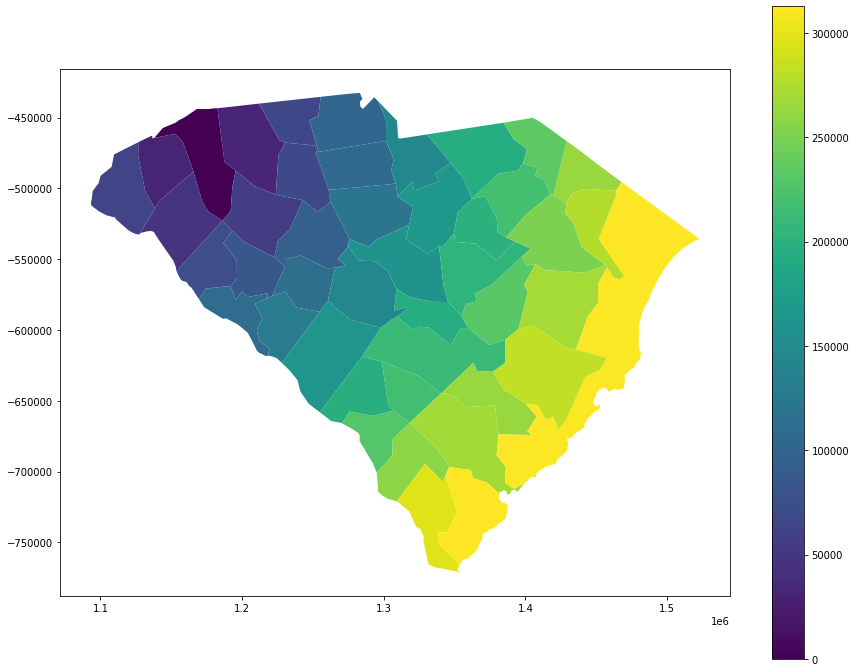

In [176]:
year =  year_list[0] 
print(f"Working on: year {year}")
us_tract_pop_df = load_year_data(year)  # no NAN

us_county_pop_df = us_tract_pop_df.groupby('CountyFIPS').agg('sum').reset_index()#.drop(columns='FIPS')
# print("us_county_pop_df.isna().sum():\n ", us_county_pop_df.isna().sum())   # no NAN

# us_county_pop_df['State_FIPS'] = us_county_pop_df['CountyFIPS'].str[:2]
# print("us_county_pop_df.isna().sum():\n ", us_county_pop_df.isna().sum())   # no NAN

us_county_pop_df['FIPS'] = us_county_pop_df['CountyFIPS']
county_pop_gdf = us_county_gdf.merge(us_county_pop_df, how='left', left_on='FIPS', right_on='FIPS').dropna()  # there are 3 counties has not population data
# print("county_pop_gdf.isna().sum():\n ", county_pop_gdf.isna().sum())   # has 3 NAN
SC_gdf = county_pop_gdf[county_pop_gdf['State_FIPS'] == '45']

SC_gdf = SC_gdf.to_crs(equidistance_crs)
SC_gdf = compute_CDB_distance_rank(SC_gdf, aggregate_column='State_FIPS')

SC_gdf.plot(column='distance_to_CBD', legend=True)

In [178]:
SC_gdf.columns

Index(['index', 'GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA',
       'FIPS', 'geometry', 'State_Name', 'State_Abbreviation', 'State_FIPS',
       'CountyFIPS', 'TotalPopulation', 'AreaTotal', 'White',
       'BlackAfricanAmerican', 'AmericanIndianAlaskaNative', 'Asian',
       'NativeHawaiianOtherPacificIslander', 'SomeOtherRace', 'TwoOrMoreRaces',
       'pop_density', 'pop_density_rank', 'pop_rank', 'tract_center_x',
       'tract_center_y', 'cbd_center_x', 'cbd_center_y', 'distance_to_CBD',
       'ditance_to_CBD_rank'],
      dtype='object')

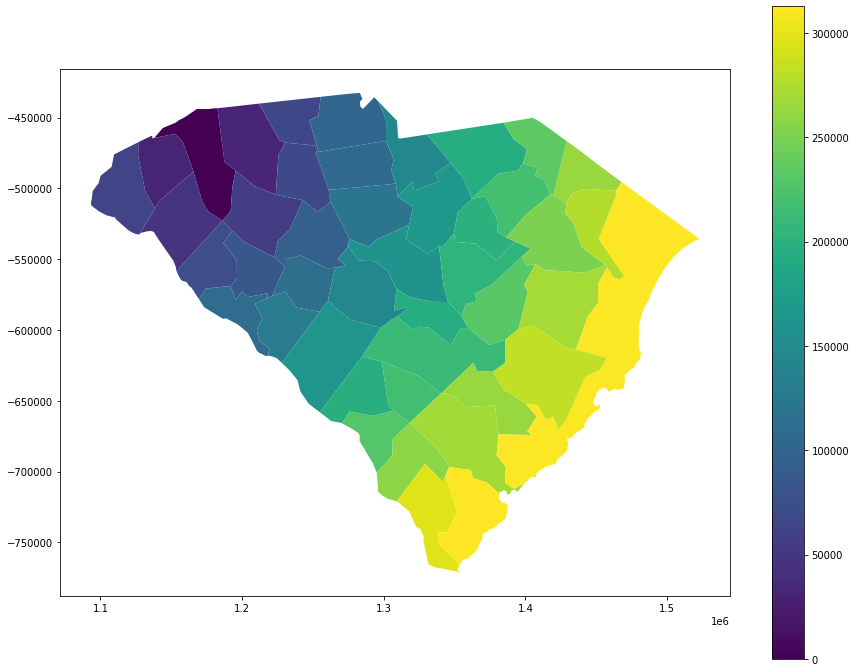

In [183]:
SC_gdf.plot(column='distance_to_CBD', legend=True)

In [ ]:
SC_gdf

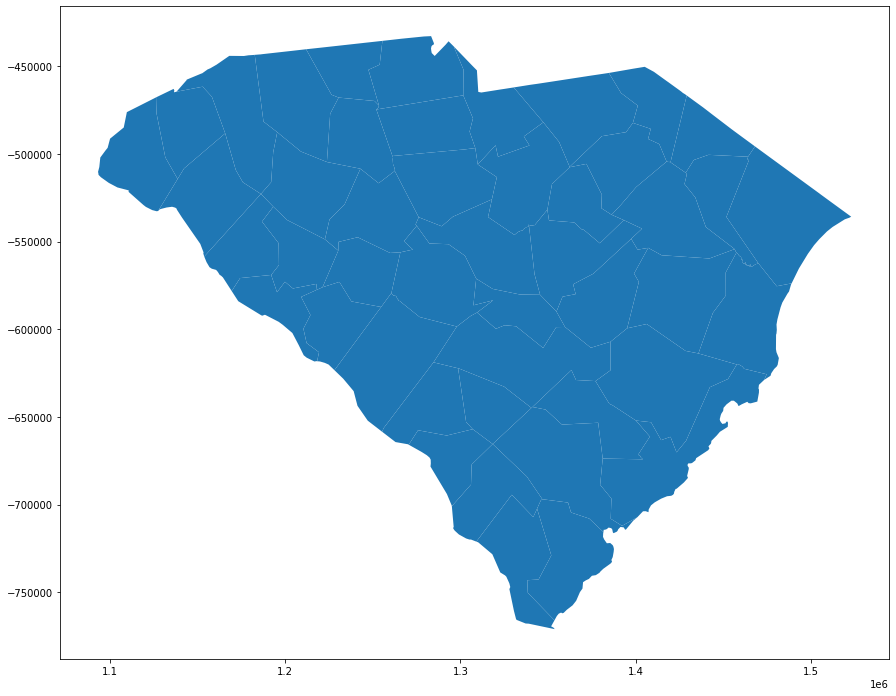

In [166]:
SC_gdf.to_crs(equidistance_crs).plot()

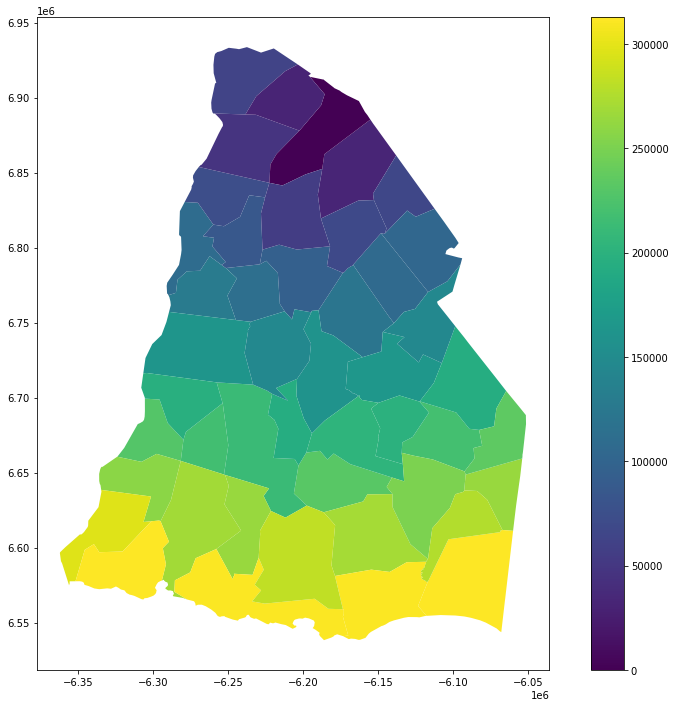

In [ ]:
df_sc = merged_CBD_gdf




# Zhenlong
# diss = df_sc.groupby(['CountyFIPS'])["White", "BlackAfricanAmerican","WhiteSum", "BlackAfricanAmericanSum"].apply(
#     lambda x : 0.5*abs(x.BlackAfricanAmerican/x.BlackAfricanAmericanSum - x.White/x.WhiteSum).sum()
# ).reset_index(name='Dissimilarity')



fig, axs = plt.subplots(1, len(indices_functions.keys()), figsize=(30, 6))


def calculate_indices():
    i = 0
    for key in indices_functions.keys():

        print("Calculating index of : ", key)

        result_df = df_sc.groupby(['CountyFIPS']).apply(
            indices_functions[key]   
        ).reset_index(name=key)  #  name=key


        result_df['CountyFIPS'] = result_df['CountyFIPS'].astype(str)
        county_gdf['fips'] = county_gdf['fips'].astype(str)

        # EPSG:2163, US National Atlas Equal Area
        # WGS84 Bounds: -66.0200, 15.3200, 168.3300, 74.7900
        # Projected Bounds: -8040784.5135, -2577524.9210, 3668901.4484, 4785105.1096

        # ax.set_xlim([-2400000,  2640000])
        # ax.set_ylim([-2400000, 1000000])

        joined_gdf = pd.merge(county_gdf, result_df, left_on='fips', right_on="CountyFIPS")
        ax = axs[i]
        ax.axis("off")
        ax.set_title(key)
        joined_gdf.to_crs(2163).plot(ax=ax,
                                    column=key, 
                                    #  vmin=0, 
                                    #  vmax=0.6, 
                                    cmap='Reds', 
                                    legend_kwds={'orientation':'vertical',"label": key},
                                    legend=True,                                   
                                    # figsize=(20, 4)).axis("off"),

                                    )

        saved_path = r'/content/drive/MyDrive/Research/segregation'
        if not os.path.exists(saved_path):
            os.makedirs(saved_path)

        new_name = os.path.join(saved_path, "segeration_" + key + ".shp")

        joined_gdf.to_file(new_name)
        i += 1

    return joined_gdf

joined_gdf = calculate_indices()


# Tools

## Calculate distance between two tracts

In [ ]:
def download_state_tract_gdf(state_codes):
    state_tract_gdf_dict = {}
    for state_code in state_codes:
        
        state_csv = f'https://github.com/gladcolor/segregation_index/raw/master/us_tract_shp/tract_shp_{state_code}.zip'
        # North American Equidistance conic:  +proj=eqdc +lat_0=0 +lon_0=0 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs
        state_gdf = gpd.read_file(state_csv).to_crs(equidistance_crs)
        state_tract_gdf_dict[state_code] = state_gdf
        print(f"Processed state code: {state_code}, got tract polygon records: {len(state_gdf)}")
    return state_tract_gdf_dict

state_codes =  us_county_gdf['STATE'].unique()

state_tract_gdf_dict = download_state_tract_gdf(state_codes)    

In [ ]:
state_tract_gdf = state_tract_gdf_dict['45']

centroids = state_tract_gdf['geometry'].centroid
centroids


0       POINT (-6229694.369 6839646.675)
1       POINT (-6241253.678 6839091.451)
2       POINT (-6257146.821 6845629.756)
3       POINT (-6248166.964 6828933.128)
4       POINT (-6257088.265 6823196.291)
                      ...               
1098    POINT (-6099452.078 6802995.374)
1099    POINT (-6104758.476 6799202.226)
1100    POINT (-6107513.548 6812986.237)
1101    POINT (-6110651.708 6811297.808)
1102    POINT (-6133476.880 6812793.929)
Length: 1103, dtype: geometry

In [ ]:
centroids.distance(centroids.iloc[-2])

0       122371.620357
1       133526.631435
2       150464.283890
3       138641.444759
4       146919.158397
            ...      
1098     13941.381255
1099     13454.861045
1100      3563.543044
1101         0.000000
1102     22874.152374
Length: 1103, dtype: float64

## Split tract files

In [ ]:
shapefile_url = r'/content/drive/MyDrive/Research/Homophily/tract_shape.zip'
tract_gdf = gpd.read_file(shapefile_url)    #.to_crs('EPSG:6569')   # EPSG:6569:  NAD83(2011) / South Carolina

# North American Equidistance conic:  +proj=eqdc +lat_0=0 +lon_0=0 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs

# us_tract_gdf = tract_gdf.to_crs(r'+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
print("Coordinate system:", tract_gdf.crs)

Coordinate system: epsg:4269


In [ ]:

# shapefile_url = r'https://github.com/GIBDUSC/Twitter-derived-human-mobility/raw/master/sc_tract.zip'
us_tract_gdf['state_code'] = us_tract_gdf['Tract'].str[:2]
us_tract_gdf

,Tract,SUM_ALAND,SUM_AWATER,geometry,state_code
0,01001020100,9817812.0,28435.0,"POLYGON ((849842.032 -790235.252, 849845.968 -...",01
1,01001020200,3325679.0,5670.0,"POLYGON ((850128.923 -788873.943, 850158.687 -...",01
2,01001020300,5349273.0,9054.0,"POLYGON ((852124.442 -788357.613, 852135.569 -...",01
3,01001020400,6384276.0,8408.0,"POLYGON ((852675.039 -788119.710, 852708.737 -...",01
4,01001020500,11408873.0,43534.0,"POLYGON ((856103.028 -790334.738, 856134.238 -...",01
...,...,...,...,...,...
74128,78030960900,8151330.0,3040065.0,"MULTIPOLYGON (((3261872.472 -1848606.600, 3261...",78
74129,78030961000,2105264.0,2358459.0,"POLYGON ((3248773.659 -1839714.021, 3248908.96...",78
74130,78030961100,3513674.0,0.0,"POLYGON ((3252066.050 -1838979.433, 3252093.41...",78
74131,78030961200,1017753.0,802134.0,"POLYGON ((3249665.327 -1839294.414, 3249782.60...",78


In [ ]:
import shutil


print("Start to split gdf to small shape files then zip them...")

cwd = os.getcwd()
print("Current working directory:", cwd)
state_codes = us_tract_gdf['state_code'].unique()

for idx, state_code in enumerate(state_codes):

    print(f'Processing: {idx + 1} / {len(state_codes)}, state code: {state_code}')
    zip_dir = os.path.join(cwd, state_code)
    os.makedirs(zip_dir, exist_ok = True)

    print(f'    Create zip file directory: {zip_dir}')
    # state_gdf = us_tract_gdf[us_tract_gdf['state_code'] == state_code]
    print(f'    Found {len(state_gdf)} tracts in the state: {state_code}')


    state_file_name = os.path.join(zip_dir, f'tract_{state_code}.shp')
    state_gdf.to_file(state_file_name)

    zipped_file_name = os.path.join(os.path.dirname(zip_dir), f'tract_shp_{state_code}')

    print('zipped_file_name:', zipped_file_name)

    shutil.make_archive(zipped_file_name, 'zip', zip_dir)


Start to split gdf to small shape files then zip them...
Current working directory: /content/drive/My Drive/Research/segregation
Processing: 1 / 56, state code: 01
    Create zip file directory: /content/drive/My Drive/Research/segregation/01
    Found 1181 tracts in the state: 01
zipped_file_name: /content/drive/My Drive/Research/segregation/tract_shp_01
Processing: 2 / 56, state code: 02
    Create zip file directory: /content/drive/My Drive/Research/segregation/02
    Found 1181 tracts in the state: 02
zipped_file_name: /content/drive/My Drive/Research/segregation/tract_shp_02
Processing: 3 / 56, state code: 04
    Create zip file directory: /content/drive/My Drive/Research/segregation/04
    Found 1181 tracts in the state: 04
zipped_file_name: /content/drive/My Drive/Research/segregation/tract_shp_04
Processing: 4 / 56, state code: 05
    Create zip file directory: /content/drive/My Drive/Research/segregation/05
    Found 1181 tracts in the state: 05
zipped_file_name: /content/driv

## Merge state index 

In [68]:
import glob
import os
import pandas as pd

shapefile_url = r'https://github.com/GIBDUSC/test/raw/master/us_counties.zip'

# county_gdf = gpd.read_file(shapefile_url).to_crs("EPSG:2163")
us_county_gdf = gpd.read_file(shapefile_url)# .to_crs(r'+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
us_county_gdf = us_county_gdf.fillna("--")  # ['County', 'Parish', 'city', '--', 'CA', 'Borough', 'Cty&Bor', 'Muny', 'Muno']
print("Coordinate systems:", us_county_gdf.crs)
print(f"Len(county_gdf): {len(us_county_gdf)}")
us_county_gdf.count

us_county_gdf['fips'] = us_county_gdf['FIPS'].str[2:]

state_csv = r'https://raw.githubusercontent.com/gladcolor/homophily/master/state_code.csv'
state_df = pd.read_csv(state_csv, dtype=str)
state_df.columns = ['State_Name', 'State_Abbreviation', 'State_FIPS']
us_county_gdf = us_county_gdf.merge(state_df, left_on='STATE', right_on='State_FIPS')

state_codes =  us_county_gdf['STATE'].unique() 

print("To process state code count: ", len(state_codes))
print(us_county_gdf['State_Name'].unique())
 

Coordinate systems: epsg:4326
Len(county_gdf): 3221
To process state code count:  52
['Alabama' 'Arkansas' 'California' 'Colorado' 'Florida' 'Georgia'
 'Connecticut' 'Arizona' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Minnesota' 'Mississippi' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New Jersey' 'New Mexico' 'North Carolina' 'Ohio' 'Oklahoma'
 'North Dakota' 'New York' 'Pennsylvania' 'South Carolina' 'Tennessee'
 'South Dakota' 'Oregon' 'Texas' 'Utah' 'Virginia' 'Washington'
 'Wisconsin' 'Wyoming' 'West Virginia' 'Vermont' 'Delaware'
 'District of Columbia' 'New Hampshire' 'Rhode Island' 'Alaska' 'Hawaii'
 'Puerto Rico']


In [67]:
us_county_gdf#[['NAME', 'fips','State_Name','State_Abbreviation','State_FIPS']]

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,FIPS,fips_1,average_20,complete_2,average_48,complete_4,average_50,complete_5,average_75,complete_7,geometry,fips,State_Name,State_Abbreviation,State_FIPS
0,0500000US01001,01,001,Autauga,County,594.436,US01001,US01001,16,12,20,19,20,19,9,65,"POLYGON Z ((-86.49677 32.34444 0.00000, -86.71...",01001,Alabama,AL,01
1,0500000US01009,01,009,Blount,County,644.776,US01009,US01009,16,14,20,15,20,15,9,73,"POLYGON Z ((-86.57780 33.76532 0.00000, -86.75...",01009,Alabama,AL,01
2,0500000US01017,01,017,Chambers,County,596.531,US01017,US01017,4,12,5,19,0,19,16,65,"POLYGON Z ((-85.18413 32.87053 0.00000, -85.12...",01017,Alabama,AL,01
3,0500000US01021,01,021,Chilton,County,692.854,US01021,US01021,16,12,20,19,20,19,9,65,"POLYGON Z ((-86.51734 33.02057 0.00000, -86.51...",01021,Alabama,AL,01
4,0500000US01033,01,033,Colbert,County,592.619,US01033,US01033,16,14,20,15,20,15,9,73,"POLYGON Z ((-88.13999 34.58170 0.00000, -88.13...",01033,Alabama,AL,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,0500000US72141,72,141,Utuado,Muno,113.529,US72141,--,0,0,0,0,0,0,0,0,"POLYGON Z ((-66.67049 18.15283 0.00000, -66.69...",72141,Puerto Rico,PR,72
3217,0500000US72071,72,071,Isabela,Muno,55.304,US72071,--,0,0,0,0,0,0,0,0,"POLYGON Z ((-66.95752 18.48917 0.00000, -66.92...",72071,Puerto Rico,PR,72
3218,0500000US72003,72,003,Aguada,Muno,30.851,US72003,--,0,0,0,0,0,0,0,0,"POLYGON Z ((-67.18285 18.31303 0.00000, -67.23...",72003,Puerto Rico,PR,72
3219,0500000US72009,72,009,Aibonito,Muno,31.311,US72009,--,0,0,0,0,0,0,0,0,"POLYGON Z ((-66.22449 18.09534 0.00000, -66.22...",72009,Puerto Rico,PR,72


In [55]:
pip install tqdm


In [56]:
from tqdm import tqdm
year_list = ["2009-2013", "2010-2014", "2011-2015", "2012-2016", "2013-2017", "2014-2018", "2015-2019"]

county_name_df = us_county_gdf[['NAME', 'fips','State_Name','State_Abbreviation','State_FIPS']]
for year in year_list[:]:
    state_index_csvs = glob.glob(f'*{year}*.csv')
    for csv in state_index_csvs:
        if csv.startswith("US_"):
            state_index_csvs.remove(csv)
    print("Processing: ", year)
    state_dfs = []
    for state_csv in tqdm(state_index_csvs):
        state_df = pd.read_csv(state_csv)
        state_dfs.append(state_df)

    print("Merging: ")

    year_all_state_df = pd.concat(state_dfs, axis=0)

    year_all_state_df['CountyFIPS'] = year_all_state_df['CountyFIPS'].astype(str).str.zfill(5)

    year_all_state_df = year_all_state_df.merge(county_name_df, how="left", left_on="CountyFIPS", right_on='fips').drop(columns='fips')

    year_all_state_df.to_csv(f"US_{year}_segregation_index.csv", index=False)
    


Processing:  2009-2013


 17%|█▋        | 9/52 [00:06<00:29,  1.47it/s]


KeyboardInterrupt: ignored

In [ ]:
year_all_state_df

,CountyFIPS,Spatial_Proximity,Dissimilarity,Isolation,Delta,Absolute_Centralization,Relative_Centralization,NAME,State_Name,State_Abbreviation,State_FIPS
0,01001,0.939413,0.248493,0.690832,0.527264,-0.048966,-0.100620,Autauga,Alabama,AL,01
1,01003,0.959022,0.412663,0.749345,0.675694,-0.019170,0.225080,Baldwin,Alabama,AL,01
2,01005,0.915311,0.181947,0.444951,0.289155,-0.127880,0.056555,Barbour,Alabama,AL,01
3,01007,0.993318,0.421894,0.667591,0.440640,-0.081372,0.440419,Bibb,Alabama,AL,01
4,01009,0.966120,0.350427,0.940869,0.428684,-0.018319,-0.042056,Blount,Alabama,AL,01
...,...,...,...,...,...,...,...,...,...,...,...
3215,72145,0.893153,0.216408,0.828155,0.381115,-0.043646,0.100047,Vega Baja,Puerto Rico,PR,72
3216,72147,0.623969,0.189339,0.566266,0.217986,-0.714286,-0.189339,Vieques,Puerto Rico,PR,72
3217,72149,0.609087,0.278785,0.558145,0.467353,-0.009056,0.164398,Villalba,Puerto Rico,PR,72
3218,72151,0.967393,0.148237,0.182934,0.192280,-0.145090,0.081070,Yabucoa,Puerto Rico,PR,72


In [ ]:
pd.concat(state_dfs, axis=0)

,CountyFIPS,Spatial_Proximity,Dissimilarity,Isolation,Delta,Absolute_Centralization,Relative_Centralization,CountyFIPS.1,Spatial_Proximity .1,Dissimilarity.1,Isolation .1,Delta.1,Absolute_Centralization.1,Relative_Centralization.1,CountyFIPS.2,Spatial_Proximity .2,Dissimilarity.2,Isolation .2,Delta.2,Absolute_Centralization.2,Relative_Centralization.2,CountyFIPS.3,Spatial_Proximity .3,Dissimilarity.3,Isolation .3,Delta.3,Absolute_Centralization.3,Relative_Centralization.3,CountyFIPS.4,Spatial_Proximity .4,Dissimilarity.4,Isolation .4,Delta.4,Absolute_Centralization.4,Relative_Centralization.4,CountyFIPS.5,Spatial_Proximity .5,Dissimilarity.5,Isolation .5,Delta.5,...,Relative_Centralization.46.1.1,CountyFIPS.47.1.1,Spatial_Proximity .47.1.1,Dissimilarity.47.1.1,Isolation .47.1.1,Delta.47.1.1,Absolute_Centralization.47.1.1,Relative_Centralization.47.1.1,CountyFIPS.48.1.1,Spatial_Proximity .48.1.1,Dissimilarity.48.1.1,Isolation .48.1.1,Delta.48.1.1,Absolute_Centralization.48.1.1,Relative_Centralization.48.1.1,CountyFIPS.49.1.1,Spatial_Proximity .49.1.1,Dissimilarity.49.1.1,Isolation .49.1.1,Delta.49.1.1,Absolute_Centralization.49.1.1,Relative_Centralization.49.1.1,CountyFIPS.50.1.1,Spatial_Proximity .50.1.1,Dissimilarity.50.1.1,Isolation .50.1.1,Delta.50.1.1,Absolute_Centralization.50.1.1,Relative_Centralization.50.1.1,CountyFIPS.51.1.1,Spatial_Proximity .51.1.1,Dissimilarity.51.1.1,Isolation .51.1.1,Delta.51.1.1,Absolute_Centralization.51.1.1,Relative_Centralization.51.1.1,NAME,State_Name,State_Abbreviation,State_FIPS
0,1001,0.948533,0.375686,0.624752,0.450222,-0.094184,-0.156937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1003,0.967547,0.447022,0.741935,0.636784,-0.043309,0.023303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1005,0.964821,0.276443,0.432677,0.283899,-0.112505,0.109584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1007,0.985984,0.399241,0.665927,0.366049,-0.043346,0.425247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1009,0.961707,0.525532,0.933369,0.495518,-0.011002,-0.201523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9903,00nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9904,00

## show state-leve segregation

In [ ]:
!pip install geopandas
import geopandas as gpd

     |████████████████████████████████| 1.0 MB 15.3 MB/s 
     |████████████████████████████████| 6.3 MB 78.1 MB/s 
     |████████████████████████████████| 15.4 MB 57.3 MB/s 


In [ ]:
import pandas as pd
csv_file = r'https://raw.githubusercontent.com/gladcolor/segregation_index/master/US_segregation_indices/US_2015-2019_segregation_index.csv'
seg_df = pd.read_csv(csv_file)
seg_df

,CountyFIPS,Spatial_Proximity,Dissimilarity,Isolation,Delta,Absolute_Centralization,Relative_Centralization,NAME,State_Name,State_Abbreviation,State_FIPS
0,1001,0.939413,0.248493,0.690832,0.527264,-0.048966,-0.100620,Autauga,Alabama,AL,1.0
1,1003,0.959022,0.412663,0.749345,0.675694,-0.019170,0.225080,Baldwin,Alabama,AL,1.0
2,1005,0.915311,0.181947,0.444951,0.289155,-0.127880,0.056555,Barbour,Alabama,AL,1.0
3,1007,0.993318,0.421894,0.667591,0.440640,-0.081372,0.440419,Bibb,Alabama,AL,1.0
4,1009,0.966120,0.350427,0.940869,0.428684,-0.018319,-0.042056,Blount,Alabama,AL,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3215,72145,0.893153,0.216408,0.828155,0.381115,-0.043646,0.100047,Vega Baja,Puerto Rico,PR,72.0
3216,72147,0.623969,0.189339,0.566266,0.217986,-0.714286,-0.189339,Vieques,Puerto Rico,PR,72.0
3217,72149,0.609087,0.278785,0.558145,0.467353,-0.009056,0.164398,Villalba,Puerto Rico,PR,72.0
3218,72151,0.967393,0.148237,0.182934,0.192280,-0.145090,0.081070,Yabucoa,Puerto Rico,PR,72.0


In [ ]:
seg_df_gb = seg_df.groupby('State_Abbreviation').mean()
seg_df_gb

,CountyFIPS,Spatial_Proximity,Dissimilarity,Isolation,Delta,Absolute_Centralization,Relative_Centralization,State_FIPS
State_Abbreviation,,,,,,,,
AK,2149.357143,0.513356,0.186358,0.506401,0.382959,-0.129109,0.051374,2.0
AL,1067.000000,0.954102,0.359903,0.585728,0.480135,-0.080792,0.049245,1.0
AR,5075.000000,0.931974,0.382221,0.726507,0.597678,-0.143160,0.055066,5.0
AZ,4013.866667,0.838629,0.463003,0.759502,0.778012,-0.041093,0.070543,4.0
CA,6058.000000,0.749604,0.427302,0.673561,0.723265,-0.030934,0.066622,6.0
CO,8062.234375,0.913821,0.341302,0.825627,0.537084,-0.124799,0.054380,8.0
CT,9008.000000,0.849905,0.520677,0.667981,0.712393,-0.019488,0.034517,9.0
DC,11001.000000,0.873455,0.653943,0.198997,0.446738,-0.011194,-0.164557,11.0
DE,10003.000000,0.915072,0.384987,0.593103,0.544291,-0.010779,-0.027266,10.0


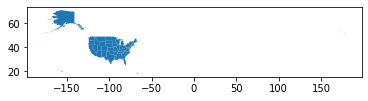

In [ ]:
state_shp = r'https://github.com/gladcolor/segregation_index/raw/master/cb_2018_us_state_20m.zip'
state_gdf = gpd.read_file(state_shp)

state_gdf.plot()

Coordinate systems: +proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs
Coordinate systems: +proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs


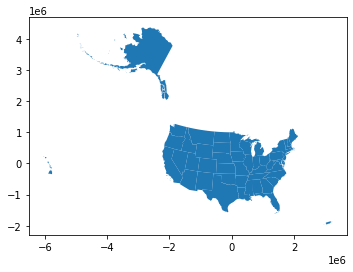

In [ ]:
# county_gdf = gpd.read_file(shapefile_url).to_crs("EPSG:2163")
# us_county_gdf = gpd.read_file(shapefile_url)# .to_crs(r'+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
print("Coordinate systems:", state_gdf.crs)
state_gdf = state_gdf.to_crs(r'+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
print("Coordinate systems:", state_gdf.crs)
state_gdf.plot()

In [ ]:
merged_gdf = state_gdf.set_index('STUSPS').merge(seg_df_gb, left_index=True, right_index=True)
merged_gdf.sample(2)

,STATEFP,STATENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,CountyFIPS,Spatial_Proximity,Dissimilarity,Isolation,Delta,Absolute_Centralization,Relative_Centralization,State_FIPS
KS,20,00481813,0400000US20,20,Kansas,00,211755344060,1344141205,"POLYGON ((-485356.734 16498.765, -467771.571 1...",20105.0,0.935319,0.252800,0.858257,0.505662,-0.132867,0.085296,20.0
MS,28,01779790,0400000US28,28,Mississippi,00,121533519481,3926919758,"POLYGON ((397948.194 -959278.868, 403172.971 -...",28082.0,0.968764,0.317199,0.482546,0.424733,-0.172184,0.038125,28.0


In [ ]:
merged_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 52 entries, MD to RI
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   STATEFP                  52 non-null     object  
 1   STATENS                  52 non-null     object  
 2   AFFGEOID                 52 non-null     object  
 3   GEOID                    52 non-null     object  
 4   NAME                     52 non-null     object  
 5   LSAD                     52 non-null     object  
 6   ALAND                    52 non-null     int64   
 7   AWATER                   52 non-null     int64   
 8   geometry                 52 non-null     geometry
 9   CountyFIPS               52 non-null     float64 
 10  Spatial_Proximity        52 non-null     float64 
 11  Dissimilarity            52 non-null     float64 
 12  Isolation                52 non-null     float64 
 13  Delta                    52 non-null     float64 
 14  Absolute

In [ ]:
merged_gdf.columns 

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND',
       'AWATER', 'geometry', 'CountyFIPS', 'Spatial_Proximity ',
       'Dissimilarity', 'Isolation ', 'Delta', 'Absolute_Centralization',
       'Relative_Centralization', 'State_FIPS'],
      dtype='object')

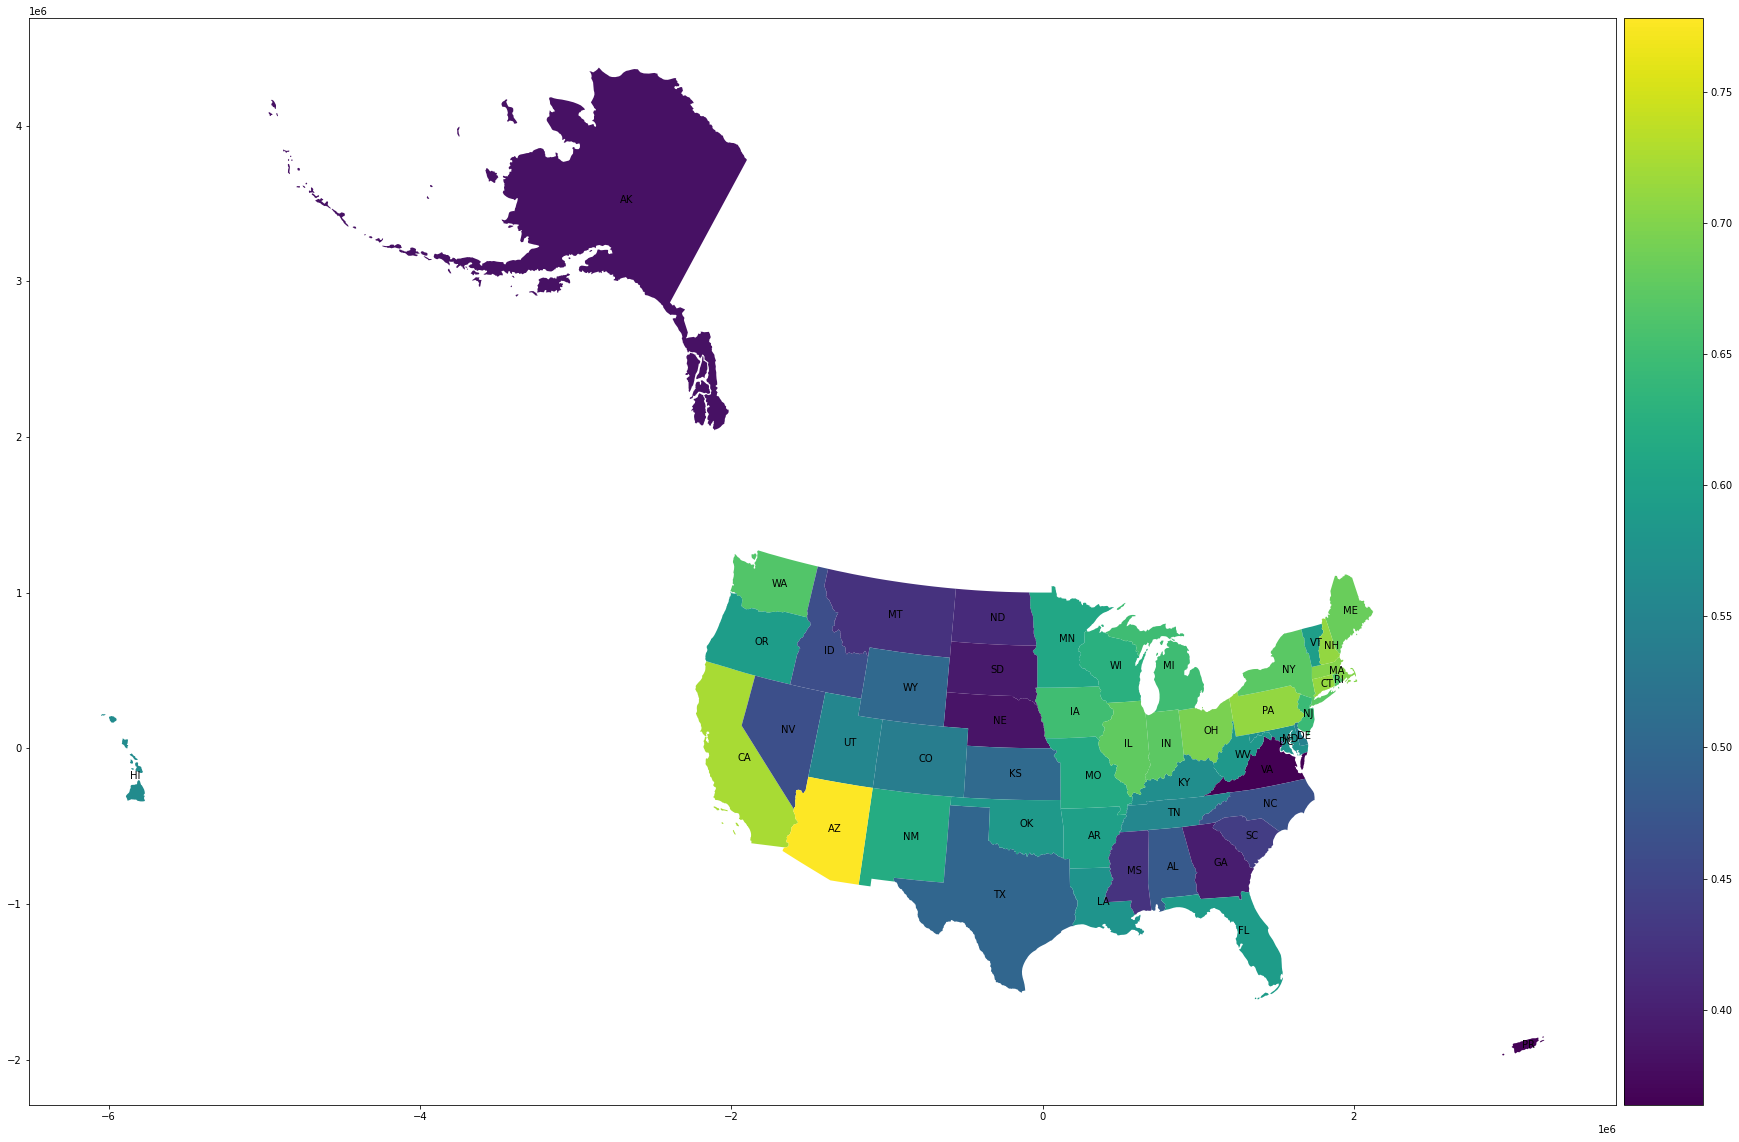

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(30, 20))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

merged_gdf.plot(ax=ax, column='Delta', legend=True, cax=cax)
 

for x, y, label in zip(merged_gdf.geometry.centroid.x, merged_gdf.geometry.centroid.y, merged_gdf.index):
    ax.annotate(label, xy=(x, y), xytext=(-3, -3), textcoords="offset points")

# plt.colorbar()

In [ ]:
merged_gdf.geometry.centroid.x

In [ ]:
for x, y, label in zip(merged_gdf.geometry.centroid.x, merged_gdf.geometry.centroid.y, merged_gdf.NAME):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

plt.show()

In [ ]:
merged_gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,CountyFIPS,Spatial_Proximity,Dissimilarity,Isolation,Delta,Absolute_Centralization,Relative_Centralization,State_FIPS
MD,24,01714934,0400000US24,24,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((1636465.973 -38920.586, 163933...",24044.958333,0.900272,0.408929,0.603005,0.572518,-0.055796,0.060551,24.0
IA,19,01779785,0400000US19,19,Iowa,00,144661267977,1084180812,"POLYGON ((-47802.905 308831.625, -44391.317 31...",19099.000000,0.947588,0.449977,0.917710,0.651564,-0.117117,0.113242,19.0
DE,10,01779781,0400000US10,10,Delaware,00,5045925646,1399985648,"POLYGON ((1616889.791 149727.000, 1617628.486 ...",10003.000000,0.915072,0.384987,0.593103,0.544291,-0.010779,-0.027266,10.0
OH,39,01085497,0400000US39,39,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((1023660.329 262158.536, 102610...",39088.000000,0.947613,0.490214,0.834756,0.694395,-0.046923,0.084060,39.0
PA,42,01779798,0400000US42,42,Pennsylvania,00,115884442321,3394589990,"POLYGON ((1219447.613 204729.770, 1217947.950 ...",42067.000000,0.936353,0.526386,0.800433,0.710843,-0.040881,0.146058,42.0


In [ ]:
Spatial_Proximity

NameError: ignored

In [ ]:
idx_columns = [ 'Dissimilarity', 'Isolation', 'Delta', 'Absolute_Centralization', 'Relative_Centralization']
# 'Spatial_Proximity',
for col in idx_columns:

    print(col)
    merged_gdf.plot(column=col)

In [9]:
year = '2009-2013'
load_year_data(year)

NameError: ignored